In [1]:
import numpy as np
import networkx as nx
import random
from networkx.generators.random_graphs import erdos_renyi_graph

# Network parameters

In [2]:
N=20 #router number
m=3 #shortest path number
sim_num=1
memsize=10000 #in mb
min_vert_degree=2 #min vertex degree
router_rate_reduction=[0.2,0.5] #router max data rate reduction range in comparisson with the maximum demand from the links
router_delay_coefficient=8 #defines delay time while the package passing through router
link_delay_coefficient=4 #defines delay time while the package passing through link

file_name_full_graph='full_graph_{}_{}.txt'.format(N,sim_num)

file_name_full_graph_optimal_path='full_graph_and_prime_shortest_path_{}_{}.txt'.format(N,sim_num)
file_name_cluster_graph='cluster_graph_{}_{}.txt'.format(N,sim_num)
file_name_shortest_path='full_graph_shortest_path_{}_{}.txt'.format(N,sim_num)
file_name_prime_routers_shortest_path='prime_graph_shortest_path_{}_{}.txt'.format(N,sim_num)
file_name_prime_graph='prime_graph_{}_{}.txt'.format(N,sim_num)

In [3]:
Umax=[100000, 150000, 200000] #link maximum data rate
prob=[0.5,0.3,0.2] #probabilities of link maximum data rates

# Graph generation

In [4]:
p=32*2/(20*19) #ARPANET's edge probability

In [5]:
p

0.16842105263157894

In [6]:
while True: #generating connected graph
    g = erdos_renyi_graph(N, p)
    d=dict(g.degree)
    
    min_degree=min(d.items(), key=lambda x: x[1])[1]
    
    if min_degree>=min_vert_degree and nx.is_connected(g):
        break
    

In [7]:
print('vertices', g.nodes) 

vertices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [8]:
print('edges', g.edges) 

edges [(0, 1), (0, 3), (0, 6), (0, 8), (0, 12), (1, 5), (1, 6), (1, 9), (1, 17), (2, 5), (2, 7), (2, 11), (2, 12), (3, 7), (3, 10), (3, 13), (4, 6), (4, 11), (4, 15), (5, 6), (6, 12), (6, 13), (6, 18), (7, 12), (8, 12), (8, 13), (8, 19), (9, 10), (10, 12), (10, 14), (10, 16), (13, 15), (13, 17), (14, 16), (14, 18), (14, 19), (15, 16)]


In [9]:
d=dict(g.degree)
    
min_degree=min(d.items(), key=lambda x: x[1])

print('min vertex degree', min_degree[1])

min vertex degree 2


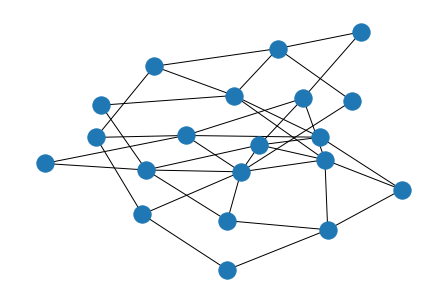

In [10]:
nx.draw(g)

## Generating network 

In [11]:
U={} 

for e in g.edges: 
    x,y=e
    U[e]=np.random.choice(Umax, p=prob) #generating max link data rate
    U[(y,x)]=U[e]

In [12]:
print('max link data rates', U)

max link data rates {(0, 1): 100000, (1, 0): 100000, (0, 3): 100000, (3, 0): 100000, (0, 6): 200000, (6, 0): 200000, (0, 8): 200000, (8, 0): 200000, (0, 12): 100000, (12, 0): 100000, (1, 5): 100000, (5, 1): 100000, (1, 6): 150000, (6, 1): 150000, (1, 9): 200000, (9, 1): 200000, (1, 17): 200000, (17, 1): 200000, (2, 5): 150000, (5, 2): 150000, (2, 7): 100000, (7, 2): 100000, (2, 11): 150000, (11, 2): 150000, (2, 12): 150000, (12, 2): 150000, (3, 7): 100000, (7, 3): 100000, (3, 10): 200000, (10, 3): 200000, (3, 13): 100000, (13, 3): 100000, (4, 6): 100000, (6, 4): 100000, (4, 11): 100000, (11, 4): 100000, (4, 15): 150000, (15, 4): 150000, (5, 6): 150000, (6, 5): 150000, (6, 12): 100000, (12, 6): 100000, (6, 13): 150000, (13, 6): 150000, (6, 18): 150000, (18, 6): 150000, (7, 12): 150000, (12, 7): 150000, (8, 12): 200000, (12, 8): 200000, (8, 13): 100000, (13, 8): 100000, (8, 19): 200000, (19, 8): 200000, (9, 10): 100000, (10, 9): 100000, (10, 12): 100000, (12, 10): 100000, (10, 14): 10000

In [21]:
router_data_rate=[0]*N

for e in g.edges: 
    x,y=e
    router_data_rate[x]+=U[(y,x)]
    router_data_rate[y]+=U[(x,y)]
    

reduction=np.random.uniform(low=router_rate_reduction[0], high=router_rate_reduction[1], size=(N,))

router_data_rate*=reduction

router_data_rate=np.maximum(1, router_data_rate//10000)*10000 #making them a multiple of 10000

In [22]:
print('router data rates', router_data_rate)

router data rates [280000. 320000. 210000. 170000. 130000. 150000. 320000.  70000. 140000.
  60000. 150000.  80000. 220000. 280000. 160000.  80000.  90000.  90000.
  80000. 130000.]


In [27]:
weight={}
const=1e6

for e in g.edges: 
    x,y=e
    weight[(x,y)]=link_delay_coefficient/U[(x,y)] + router_delay_coefficient/router_data_rate[y]   
    weight[(y,x)]=link_delay_coefficient/U[(y,x)] + router_delay_coefficient/router_data_rate[x] 

In [28]:
weight

{(0, 1): 6.500000000000001e-05,
 (1, 0): 6.857142857142858e-05,
 (0, 3): 8.705882352941177e-05,
 (3, 0): 6.857142857142858e-05,
 (0, 6): 4.5e-05,
 (6, 0): 4.857142857142857e-05,
 (0, 8): 7.714285714285714e-05,
 (8, 0): 4.857142857142857e-05,
 (0, 12): 7.636363636363637e-05,
 (12, 0): 6.857142857142858e-05,
 (1, 5): 9.333333333333334e-05,
 (5, 1): 6.500000000000001e-05,
 (1, 6): 5.166666666666667e-05,
 (6, 1): 5.166666666666667e-05,
 (1, 9): 0.00015333333333333334,
 (9, 1): 4.5e-05,
 (1, 17): 0.00010888888888888889,
 (17, 1): 4.5e-05,
 (2, 5): 7.999999999999999e-05,
 (5, 2): 6.476190476190476e-05,
 (2, 7): 0.00015428571428571428,
 (7, 2): 7.80952380952381e-05,
 (2, 11): 0.00012666666666666666,
 (11, 2): 6.476190476190476e-05,
 (2, 12): 6.303030303030302e-05,
 (12, 2): 6.476190476190476e-05,
 (3, 7): 0.00015428571428571428,
 (7, 3): 8.705882352941177e-05,
 (3, 10): 7.333333333333333e-05,
 (10, 3): 6.705882352941177e-05,
 (3, 13): 6.857142857142858e-05,
 (13, 3): 8.705882352941177e-05,
 (

# Saving graph to file

In [30]:
with open('test/'+file_name_full_graph, 'w') as f:
    
    f.write('{}\n\n'.format(N))
    #f.write('\n')
    for e in g.edges:
        x,y=e
 
        f.write(str(x+1)+' '+str(y+1)+' '+str(weight[(x,y)])+'\n')
        f.write(str(y+1)+' '+str(x+1)+' '+str(weight[(y,x)])+'\n')
        
    
    f.close()

# Saving full graph

In [ ]:
with open('test/'+file_name_full_graph, 'w') as f:
    
    f.write('{}\n\n'.format(n+N))
    #f.write('\n')
    for e in g.edges:
        x,y=e

        edges.append([x+1,y+1,weight[(x+1,y+1)]])
            
            
        f.write(str(x+1)+' '+str(y+1)+' '+str(weight[(x+1,y+1)])+'\n')
        f.write(str(y+1)+' '+str(x+1)+' '+str(weight[(x+1,y+1)])+'\n')
        
    
    f.close()

# Loading the clustering graph

In [ ]:
from yen import YenAlgorithm
import tools

In [ ]:
clust_graph, _, _, _ = tools.getGraphStructure(file_name_cluster_graph) #test_10.txt

In [ ]:
print(clust_graph)

# Saving the shortest paths between very pair of vertices of the cluster graph

In [ ]:
with open('test/'+file_name_shortest_path, 'w') as f:
    
    f.write('{} {}\n'.format(n,N))

    for i in range(n+N):
        for j in range(n+N):
            if i != j:
                shortest_path_tree = YenAlgorithm(clust_graph, i, j, 1)
                #print(i,j,shortest_path_tree,'\n')
                #tools.printPaths(shortest_path_tree)
                
                if not (i==0 and j==1):
                    f.write('\n')
                    
                f.write(str(i+1)+' '+str(j+1)+'\n')
                
                for el in shortest_path_tree:
                    f.write(str(el['cost'])+'\n')
                    #print(el['path'])
                    #print('getCompletePath',tools.getCompletePath(el))
                    #path=tools.getCompletePath(el['path'])
                    #f.write(' '.join(map(str,el['path']))+'\n')
                    path=tools.getCompletePath(el)
                    path = [str(e+1) for e in path]

                    f.write(' '.join(path)+'\n')
                    
    f.close()
    

# Saving prime graph m shortest paths

In [ ]:
prime_graph, _, _, _ = tools.getGraphStructure(file_name_prime_graph)

In [ ]:
with open('test/'+file_name_prime_routers_shortest_path, 'w') as f:
    
    f.write(str(n)+'\n\n')

    for i in range(n):
        for j in range(n):
            if i != j:
                shortest_path_tree = YenAlgorithm(prime_graph, i, j, m)
                #print(i,j,shortest_path_tree,'\n')
                #tools.printPaths(shortest_path_tree)
                
                if not (i==0 and j==1):
                    f.write('\n')
                    
                f.write(str(i+1)+' '+str(j+1)+'\n')
                
                for el in shortest_path_tree:
                    f.write(str(el['cost'])+'\n')
                    #print(el['path'])
                    #print('getCompletePath',tools.getCompletePath(el))
                    #path=tools.getCompletePath(el['path'])
                    #f.write(' '.join(map(str,el['path']))+'\n')
                    path=tools.getCompletePath(el)
                    path = [str(e+1) for e in path]

                    f.write(' '.join(path)+'\n')
                    
    f.close()
    

# Saving shortest path in full graph

In [ ]:
full_graph, _, _, _ = tools.getGraphStructure(file_name_shortest_path)

In [ ]:
with open('test/'+file_name_full_graph_optimal_path, 'w') as f:
    
    f.write('{} {}\n'.format(n,N))

    for i in range(n+N):
        for j in range(n+N):
            if i != j:
                shortest_path_tree = YenAlgorithm(full_graph, i, j, 1)
                #print(i,j,shortest_path_tree,'\n')
                #tools.printPaths(shortest_path_tree)
                
                if not (i==0 and j==1):
                    f.write('\n')
                    
                f.write(str(i+1)+' '+str(j+1)+'\n')
                
                for el in shortest_path_tree:
                    f.write(str(el['cost'])+'\n')
                    #print(el['path'])
                    #print('getCompletePath',tools.getCompletePath(el))
                    #path=tools.getCompletePath(el['path'])
                    #f.write(' '.join(map(str,el['path']))+'\n')
                    path=tools.getCompletePath(el)
                    path = [str(e+1) for e in path]

                    f.write(' '.join(path)+'\n')
                    
    f.close()